In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Subset

from torchvision.transforms import v2
import torchvision.utils as vutils
from torchvision import datasets

Before turning to Tabular VAE's, we make a classical one on the MNIST dataset. Both (fully convolutional) networks consist of three convolutional layers.

In [356]:
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()
        
        # Encoder network
        self.encoder = nn.Sequential(
            # Reduce the 28 x 28 dimension to 
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),
           # Reduce the 28 x 28 dimension to  9x9
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
           # Reduce the 9 x 9 dimension to  4x4
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True)  # outputs 4x4 images with 16 channels
        )
        
        # Latent space part of the VAE
        self.fc_mu = nn.Linear(16 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(16 * 4 * 4, latent_dim)
        self.fc_decoder = nn.Linear(latent_dim, 16 * 4 * 4)
        
        # Decoder network
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  
        )
        
        self.train_losses = []
        
    def encode(self, x):
        """Turn the image data into a latent space representation (isotropic gaussian)"""
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flattening the output to a 4 x 4 x 16 = 256 dimensional vector

        mu = self.fc_mu(x)         # Add a single fully connected layer to tune x to fit the mean of the variational posterior better.
        logvar = self.fc_logvar(x) # Same as for mu.
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Turns the last layer of the decoder into parameters of the variational posterior (gaussian estimate)"""
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu
    
    def decode(self, z):
        """text"""
        x = self.fc_decoder(z)
        x = x.view(-1, 16, 4, 4) # Unflattening
        return self.decoder(x)
    
    def compute_reconstruction(self, data):
        data_encoded = self.encode(data)
        data_posterior = self.reparameterize(data)
        data_recoded = self.decode(data_posterior[0], data_posterior[1])

        return data_recoded
        
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recoded = self.decode(z)
        return x_recoded, mu, logvar
    
    def loss_function(self, recon_x, x, mu, logvar, beta=1.0):

        BCE = nn.BCELoss(reduction='sum')(recon_x, x)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        return BCE + beta * KLD, BCE, KLD
    
    def train_batch():
        pass
        self.train()
        train_loss = 0

    def train_model():
        pass

    def train_epoch():
        pass    
    
    def generate_images(self):
        pass
    
    def save_parameters(self):
        """Saves the model parameters to the current directory."""
        current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        torch.save(self.state_dict(), f"VAE_{current_time}.pth")
        print(f"Successfully saved the model parameters to VAE_{current_time}.pth")
    
    def load_parameters(self, path):
        """Loads the model parameters from the specified path."""
        self.load_state_dict(torch.load(path))
        print(f"Successfully loaded the model parameters from {path}!")
    
    def plot_training_loss(self):
        """Plots the training loss over time."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title("VAE Training Loss")
        plt.show()

In [357]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = v2.Compose([
    v2.ToImage(), 
    v2.RandomAffine(degrees=7, translate=(0.1, 0.1)),
    v2.ToDtype(torch.float32, scale=True)] 
    )

train_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
test_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

For now we a latent dimension of 8 is chosen. This is very low so we cannot expect enough data to be stored in this representation

In [376]:
def train_vae(model, train_loader, optimizer, epoch, annealing_epochs=50):
    model.train()
    train_loss = 0
    bce_epoch = 0
    kld_epoch = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        batch_recoded, mu, logvar = model(data)
        
        # Kullback Leibler annealing
        beta = min(epoch / annealing_epochs, 1)

        loss, bce, kld = model.loss_function(batch_recoded, data, mu, logvar, beta)
        
        # Backward pass and optimize
        loss.backward()
        train_loss += loss.item()
        bce_epoch += bce
        kld_epoch += kld

        optimizer.step()
            
    avg_loss = train_loss / len(train_loader.dataset)
    avg_bce =  bce_epoch / len(train_loader.dataset)
    avg_kld =  kld_epoch / len(train_loader.dataset)ppend(avg_loss)
    print(f'Epoch {epoch} -- Average loss: {avg_loss:.2f}  |  BCE: {avg_bce:.1f}  |  KLD: {avg_kld:.1f}')


latent_dim = 8
vae = VAE(latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=3e-4)


In [377]:
num_epochs = 50
for epoch in range(num_epochs):
    train_vae(vae, train_loader, optimizer, epoch)

Epoch 0 -- Average loss: 379.49  |  BCE: 22769458  |  KLD: 2177349
Epoch 1 -- Average loss: 218.77  |  BCE: 13073698  |  KLD: 2612516
Epoch 2 -- Average loss: 176.13  |  BCE: 10482186  |  KLD: 2147578
Epoch 3 -- Average loss: 160.87  |  BCE: 9537669  |  KLD: 1913034
Epoch 4 -- Average loss: 152.07  |  BCE: 8983205  |  KLD: 1763888
Epoch 5 -- Average loss: 146.01  |  BCE: 8591721  |  KLD: 1690981
Epoch 6 -- Average loss: 142.10  |  BCE: 8328928  |  KLD: 1642896
Epoch 7 -- Average loss: 139.54  |  BCE: 8147802  |  KLD: 1602284
Epoch 8 -- Average loss: 137.71  |  BCE: 8011076  |  KLD: 1571155
Epoch 9 -- Average loss: 136.42  |  BCE: 7907148  |  KLD: 1544128
Epoch 10 -- Average loss: 135.47  |  BCE: 7824058  |  KLD: 1519365
Epoch 11 -- Average loss: 134.93  |  BCE: 7767084  |  KLD: 1495222
Epoch 12 -- Average loss: 134.43  |  BCE: 7712459  |  KLD: 1473411
Epoch 13 -- Average loss: 134.10  |  BCE: 7668256  |  KLD: 1452752
Epoch 14 -- Average loss: 133.99  |  BCE: 7638536  |  KLD: 1432238
Ep

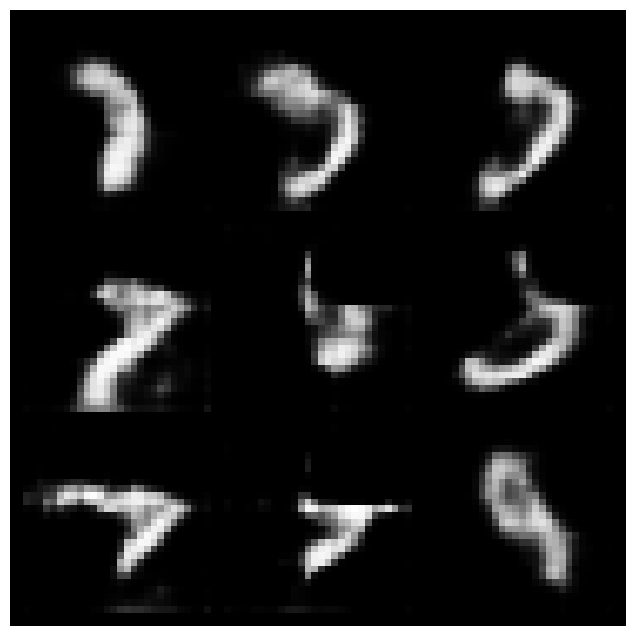

In [380]:
def generate_samples_grid(model, num_samples=9, device=device):
    model.eval()
    
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)  
        samples = model.decode(z)
        grid = vutils.make_grid(samples, nrow=3, normalize=True, padding=2)
        
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)), cmap='gray')
        plt.axis('off')
        plt.show()

generate_samples_grid(vae)

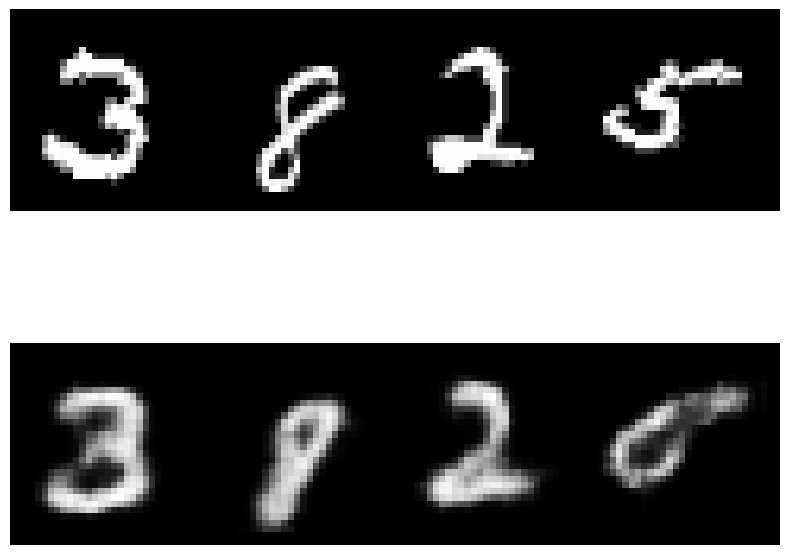

In [381]:
vae.eval()
    
with torch.no_grad():
    for batch in train_loader:
        original_data = batch[0].to(device) 
        break

idx = np.random.choice(range(128), 4, replace=False)
original_data = original_data[idx]

mu, _ = vae.encode(original_data)
z = vae.reparameterize(mu, -1)
reconstructed_data = vae.decode(z)

original_grid = vutils.make_grid(original_data, nrow=4, normalize=True, padding=2)
reconstructed_grid = vutils.make_grid(reconstructed_data, nrow=4, normalize=True, padding=2)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.imshow(original_grid.cpu().numpy().transpose((1, 2, 0)), cmap='gray')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(reconstructed_grid.cpu().numpy().transpose((1, 2, 0)), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [382]:
# In this chunk we will try to plot an interpolation between images

vae.eval()
with torch.no_grad():
    for batch in train_loader:
        original_data = batch[0].to(device)  # Assume batch[0] contains images
        break

Below we are able to interpolate images. These interpolated images make it clear that images inbetween may not always be sensible.
This might also be the case when applying VAE's to tabular data

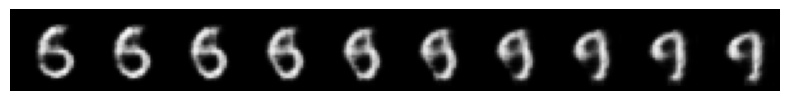

In [416]:
idx = np.random.choice(range(128), 2, replace=False)
original_data_idx = original_data[idx]

mu, _ = vae.encode(original_data_idx)
z = vae.reparameterize(mu, -1)
reconstructed_data = vae.decode(z)

t_values = torch.linspace(0, 1, 10)
interpolated_points = [(1 - t) * z[0] + t * z[1] for t in t_values]
interpolated_points = torch.stack(interpolated_points)
interpolated_images = vae.decode(interpolated_points)

grid = vutils.make_grid(interpolated_images, nrow=10, normalize=True, padding=2)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

grid = vutils.make_grid(interpolated_images, nrow=10, normalize=True, padding=0)

Extract all latent representations and corresponding labels so we can plot them

In [417]:
vae.eval()

latent_images = torch.empty((0, latent_dim))
labels = torch.empty((0, ))

with torch.no_grad():
    for batch in train_loader:

        mu, _ = vae.encode(batch[0])

        latent_images = torch.cat((latent_images, mu), dim=0)
        labels = torch.cat((labels, batch[1]), dim=0)

Displaying the latent representations of different images projected on a 2-dimensional scatter plot (projection dimensions are chosen randomly)

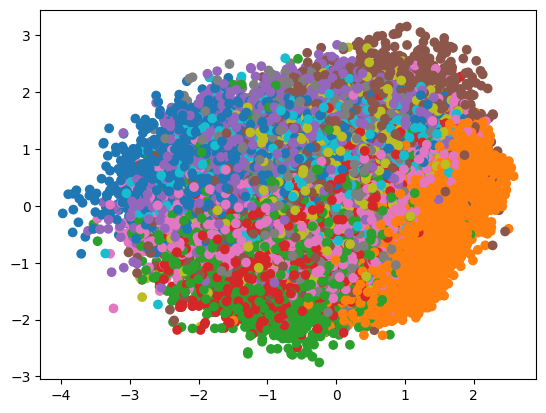

In [422]:
idx_dim = np.random.choice(range(latent_dim), 2, replace=False)

plt.scatter(latent_images[:, idx_dim[0]], 
            latent_images[:, idx_dim[1]],
            c = labels,
            cmap='tab10')

In [350]:
latent_dim

8